In [1]:
import warnings
from IPython.utils import io
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


with io.capture_output() as captured:
    import sys

    import matplotlib.pyplot as plt
    import mbuild
    import nglview
    import mdtraj

    from tqdm import tqdm
    from rdkit import Chem
    from rdkit.Chem import Draw

    import openmm
    from openff import toolkit, utilities, interchange, models
    from openff.toolkit import topology 
    from openff.units import unit
    from openff.interchange.components._packmol import UNIT_CUBE, pack_box

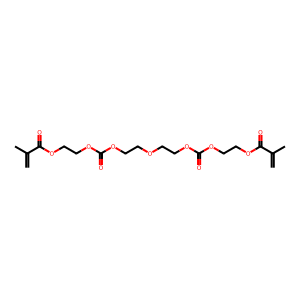

In [2]:
molecules_rdkit = dict(
    ocm2=Chem.MolFromSmiles('CC(C(OCCOC(OCCOCCOC(OCCOC(C(C)=C)=O)=O)=O)=O)=C'),
    dmag=Chem.MolFromSmiles('C=C(C)C(OCCOC(C(C)=C)=O)=O'),
    peta=Chem.MolFromSmiles('C=CC(OCC(COC(C=C)=O)(COC(C=C)=O)CO)=O'),
    butanol1=Chem.MolFromSmiles('OCCCC'),
)
Draw.MolToImage(molecules_rdkit['ocm2'])

In [38]:
molecules = {}
for molecule_name, rdkit_mol in molecules_rdkit.items():
    mol = toolkit.Molecule.from_rdkit(rdkit_mol)
    molecules[molecule_name] = mol
    mol.generate_conformers(n_conformers=1)
    mol.name = molecule_name

    for atom in mol.atoms:
        atom.metadata["residue_name"]=molecule_name[:3].upper()
    mol.add_hierarchy_scheme(iterator_name='residue',uniqueness_criteria=['residue_name'])

In [39]:
with io.capture_output() as captured:    
    a = molecules['ocm2']
    view= a.visualize(backend='nglview')
view

NGLWidget()

# Parametrize

In [ ]:
# inters = {}
# for key in tqdm(iterable=molecules):

#     mol = molecules[key]
#     mol.assign_partial_charges(
#         partial_charge_method="am1bcc",
#         use_conformers=mol.conformers,
#     )
#     top = mol.to_topology()
#     ff = toolkit.ForceField('openff_unconstrained-2.1.0.offxml')
#     inter = interchange.Interchange.from_smirnoff(
#         force_field=ff,
#         topology=top,
#         charge_from_molecules=[mol],
#         partial_bond_orders_from_molecules=[mol],
#         allow_nonintegral_charges=True,
#     )
#     inters[key] = inter
# topology = {key: mol.to_topology() for key, mol in molecules.items()}

# Pack

In [41]:
box=pack_box(
    molecules=[molecules['butanol1'],molecules['ocm2']],
    number_of_copies= [30]*2,
    mass_density=500 * unit.kilogram / unit.meter**3,
    box_shape=UNIT_CUBE
)

In [53]:
with io.capture_output() as captured:   
    view = box.visualize()
view


NGLWidget()

In [43]:
# FIXME: Doesn't load and save uncorrect 
box.to_file(
    file='box_top.pdb',
    # ensure_unique_atom_names='residue_name',
    ensure_unique_atom_names=False,
    # keep_ids=True,
)
# box2= toolkit.Topology.from_pdb('box_top.pdb',unique_molecules=[molecules['butanol1'],molecules['ocm2']])

In [49]:
with open('box_top.json','w') as file:
    box_j=box.to_json()
    file.write(box_j)

In [4]:
with open('box_top.json','r') as file:
    box_j= file.read()
    box2 = toolkit.Topology.from_json(box_j)

In [54]:
ff = toolkit.ForceField('openff_unconstrained-2.1.0.offxml')
box_parametrized= interchange.Interchange.from_smirnoff(
    force_field=ff,
    topology=box2,
)

In [55]:
box_parametrized.to_pdb("out.pdb")

In [ ]:
box_parametrized.minimize()

In [ ]:
# Logging options.
trj_freq = 10  # number of steps per written trajectory frame
data_freq = 10  # number of steps per written simulation statistics

# Integration options
time_step = 2 * openmm.unit.femtoseconds  # simulation timestep
temperature = 300 * openmm.unit.kelvin  # simulation temperature
friction = 1 / openmm.unit.picosecond  # friction constant

integrator = openmm.LangevinIntegrator(temperature, friction, time_step)

In [ ]:
sim = box_parametrized.to_openmm_simulation(integrator=integrator)
sim.context.setVelocitiesToTemperature(temperature)
reporters = [
    openmm.app.StateDataReporter(sys.stdout, trj_freq, step=True),
    openmm.app.DCDReporter(
        'traj.dcd',
        trj_freq,  # enforcePeriodicBox=False,
    ),
    openmm.app.PDBReporter('solve2.pdb', trj_freq),
]
sim.reporters.extend(reporters)

In [ ]:
sim.step(1000)

In [ ]:
nglview.show_mdtraj(mdtraj.load('/home/base/WSL_base/Find_D/solve2.pdb'))